In [1]:
import math
import time

import numpy as np
import polars as pl
from sklearn.model_selection import train_test_split

In [2]:
class FunkSVD:
    def __init__(self, k=40, learning_rate=0.001, regulation=0.02, iterations=10):
        self.k = k
        self.learning_rate = learning_rate
        self.regulation = regulation
        self.iterations = iterations

        self.global_mean = None
        self.users_bias = None
        self.items_bias = None
        self.P_matrix = None
        self.Q_matrix = None

        # RMSE
        self.rmse_train_errors = None
        self.rmse_test_error = None

        # MAE
        self.mae_train_errors = None
        self.mae_test_error = None

    def fit(self, X_user_item, y_rating):
        rating_n_rows = y_rating.shape[0]

        self.global_mean = y_rating.select('rating').mean()['rating'][0]

        n_users = X_user_item.select('userId').max().rows()[0][0]
        n_items = X_user_item.select('movieId').max().rows()[0][0]

        self.users_bias = np.zeros(shape=n_users)
        self.items_bias = np.zeros(shape=n_items)

        self.P_matrix = np.full(shape=(n_users, self.k), fill_value=0.1, dtype=np.float64)
        self.Q_matrix = np.full(shape=(n_items, self.k), fill_value=0.1, dtype=np.float64)

        _rmse_train_errors = np.zeros(shape=self.iterations)
        _mae_train_errors = np.zeros(shape=self.iterations)

        for n_iteration in range(self.iterations):
            print(f'TRAINING - ITERAÇÃO: {n_iteration}')
            sq_error = 0
            mae_error = 0
            for r_matrix_row in range(rating_n_rows):

                user = X_user_item[r_matrix_row].select('userId').rows()[0][0] - 1
                item = X_user_item[r_matrix_row].select('movieId').rows()[0][0] - 1
                real_r = y_rating[r_matrix_row].select('rating').rows()[0][0]

                pred_r = self.global_mean + self.users_bias[user] + self.items_bias[item] + np.dot(self.P_matrix[user], self.Q_matrix[item])
                error_ui = real_r - pred_r
                sq_error = sq_error + error_ui ** 2
                mae_error = mae_error + abs(error_ui)

                self.users_bias[user] = self.users_bias[user] + self.learning_rate * (error_ui - self.regulation * self.users_bias[user])
                self.items_bias[item] = self.items_bias[item] + self.learning_rate * (error_ui - self.regulation * self.items_bias[item])

                for factor in range(self.k):
                    temp_uf = self.P_matrix[user, factor]
                    self.P_matrix[user, factor] = self.P_matrix[user, factor] + self.learning_rate * (error_ui * self.Q_matrix[item, factor] - self.regulation * self.P_matrix[user, factor])
                    self.Q_matrix[item, factor] = self.Q_matrix[item, factor] + self.learning_rate * (error_ui * temp_uf - self.regulation * self.Q_matrix[item, factor])
            _rmse_train_errors[n_iteration] = round(math.sqrt(sq_error / rating_n_rows), 4)  # RMSE
            _mae_train_errors[n_iteration] = round(sq_error / rating_n_rows, 4)  # MAE
            print(f'TRAINING - RMSE: {round(math.sqrt(sq_error / rating_n_rows), 4)} - MAE: {round(sq_error / rating_n_rows, 4)}')

        self.rmse_train_errors = pl.DataFrame(np.array([_rmse_train_errors, list(range(1, self.iterations + 1))]), schema=[("rmse", pl.Float64), ("iteration", pl.Int64)], orient="col")
        self.mae_train_errors = pl.DataFrame(np.array([_mae_train_errors, list(range(1, self.iterations + 1))]), schema=[("mae", pl.Float64), ("iteration", pl.Int64)], orient="col")

        self.rmse_train_errors.write_csv('./_rmse_train_errors.csv')
        self.mae_train_errors.write_csv('./_mae_train_errors.csv')

    def predict_rating(self, user_id, item_id):
        return round(self.global_mean + self.users_bias[user_id - 1] + self.items_bias[item_id - 1] + np.dot(self.P_matrix[user_id - 1], self.Q_matrix[item_id - 1]), 4)

    def evaluate(self, X_user_item, y_rating):
        rating_n_rows = X_user_item.shape[0]
        sq_error = 0
        mae_error = 0

        for row_index in range(rating_n_rows):
            user_id = X_user_item[row_index].rows()[0][0]
            item_id = X_user_item[row_index].rows()[0][1]
            real_rating = y_rating[row_index].rows()[0][0]
            predicted_rating = self.predict_rating(user_id, item_id)

            error_ui = real_rating - predicted_rating
            sq_error = sq_error + error_ui ** 2
            mae_error = mae_error + abs(error_ui)

        self.rmse_test_error = round(math.sqrt(sq_error / rating_n_rows), 4)
        self.mae_test_error = round(mae_error / rating_n_rows, 4)

In [3]:
df_movies = pl.read_csv('./movies.csv')
df_ratings = pl.read_csv('./ratings.csv')
df_ratings = df_ratings.drop('timestamp')
df_ratings = df_ratings.sort('userId')

In [4]:
df_ratings.head(5)

userId,movieId,rating
i64,i64,f64
1,1,4.0
1,3,4.0
1,6,4.0
1,47,5.0
1,50,5.0


In [5]:
df_ratings.describe()

statistic,userId,movieId,rating
str,f64,f64,f64
"""count""",100836.0,100836.0,100836.0
"""null_count""",0.0,0.0,0.0
"""mean""",326.127564,19435.295718,3.501557
"""std""",182.618491,35530.987199,1.042529
"""min""",1.0,1.0,0.5
"""25%""",177.0,1199.0,3.0
"""50%""",325.0,2991.0,3.5
"""75%""",477.0,8121.0,4.0
"""max""",610.0,193609.0,5.0


In [6]:
X = df_ratings.select(['userId', 'movieId'])
y = df_ratings.select('rating')
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

model = FunkSVD()

In [7]:
print(f'INICIANDO TREINAMENTO...')
start_trainning = time.time()
model.fit(X_train, y_train)
print(f'FINALIZANDO TREINAMENTO...')
end_trainning = time.time()

INICIANDO TREINAMENTO...
TRAINING - ITERAÇÃO: 0
TRAINING - RMSE: 1.0375 - MAE: 1.0764
TRAINING - ITERAÇÃO: 1
TRAINING - RMSE: 0.9759 - MAE: 0.9524
TRAINING - ITERAÇÃO: 2
TRAINING - RMSE: 0.9524 - MAE: 0.9071
TRAINING - ITERAÇÃO: 3
TRAINING - RMSE: 0.9384 - MAE: 0.8806
TRAINING - ITERAÇÃO: 4
TRAINING - RMSE: 0.9285 - MAE: 0.8622
TRAINING - ITERAÇÃO: 5
TRAINING - RMSE: 0.9209 - MAE: 0.848
TRAINING - ITERAÇÃO: 6
TRAINING - RMSE: 0.9146 - MAE: 0.8365
TRAINING - ITERAÇÃO: 7
TRAINING - RMSE: 0.9093 - MAE: 0.8268
TRAINING - ITERAÇÃO: 8
TRAINING - RMSE: 0.9047 - MAE: 0.8185
TRAINING - ITERAÇÃO: 9
TRAINING - RMSE: 0.9007 - MAE: 0.8112
FINALIZANDO TREINAMENTO...


In [8]:
print(f'INICIANDO VALIDAÇÃO...')
start_evaluation = time.time()
model.evaluate(X_test, y_test)
print(f'FINALIZANDO VALIDAÇÃO...')
end_evaluation = time.time()

print(model.rmse_test_error)
print(model.mae_test_error)

INICIANDO VALIDAÇÃO...
FINALIZANDO VALIDAÇÃO...
0.9201
0.7089


In [9]:
end_trainning - start_trainning

74.65233492851257

In [10]:
model.rmse_train_errors

rmse,iteration
f64,i64
1.0375,1
0.9759,2
0.9524,3
0.9384,4
0.9285,5
0.9209,6
0.9146,7
0.9093,8
0.9047,9


In [12]:
model.mae_train_errors

mae,iteration
f64,i64
1.0764,1
0.9524,2
0.9071,3
0.8806,4
0.8622,5
0.848,6
0.8365,7
0.8268,8
0.8185,9


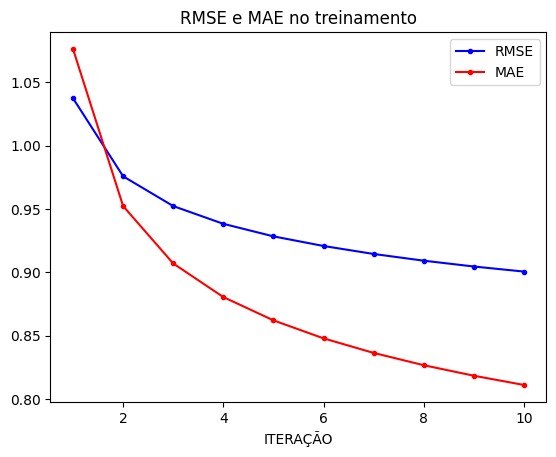

In [11]:
import matplotlib.pyplot as plt

rmse_iterations = model.rmse_train_errors["iteration"].to_list()
rmse_list = model.rmse_train_errors["rmse"].to_list()

mae_iterations = model.mae_train_errors["iteration"].to_list()
mae_list = model.mae_train_errors["mae"].to_list()

plt.style.use('default')
plt.plot(rmse_iterations, rmse_list, marker='.', linestyle='-', color='b', label='RMSE')
plt.plot(mae_iterations, mae_list, marker='.', linestyle='-', color='r', label='MAE')
plt.xlabel("ITERAÇÃO")
plt.title("RMSE e MAE no treinamento")
plt.grid(False)
plt.legend()
plt.show()